Digital Signal Processing

In [1]:
import math
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

from numba import njit
from numba.typed import List

# QR decomposition

In [2]:
def QR_hh(A):
    """
    Returns the QR decomposition for
    a general shape real matrix
    """
    m, n = A.shape
    Q = np.identity(m, dtype=A.dtype)
    R = A.copy()

    
    for k in range(min(m, n)):
        u = R[k:, k].copy()
        sigma = np.linalg.norm(u)
        s = 1 if R[k, k] >= 0 else -1
        u[0] += s*sigma
        rho = s / (sigma*u[0])
        
        R[k:] -= (rho*u[:, None]) * (u @ R[k:])
        Q[:,k:] -= (Q[:,k:] @ u)[:, None] * (rho*u)
        
    return Q, R

In [3]:
A = np.random.rand(20, 30)
Q, R = QR_hh(A)

# Check that Q and R are indeed factors of A
np.linalg.norm(A - Q@R) / np.linalg.norm(A)

4.3347561602462036e-16

4.440892098500626e-16

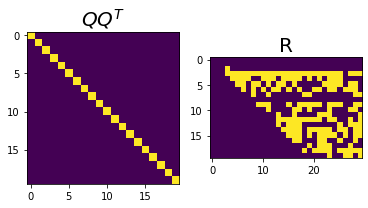

In [4]:
# Check that Q is orthonormal and R is upper-triangular
QQT = Q@Q.T
plt.subplot('121')
plt.title(r'$QQ^T$', size=20)
plt.imshow(QQT);

plt.subplot('122')
plt.title('R', size=20)
plt.imshow(R > 1e-15);

# Maximamum deviation of diagonal entries from 1
np.abs(np.diag(QQT) - 1).max()

# Linear and circular convolutions

There are two ways to calculate a convolution that come up to my mind.
The first is the direct one, where you follow the definition of the convolution type.
And the second is to apply FFT, which suits circular convolutions
and can be adjusted for the linear one via zero padding.

FFT is asymptotically (length of signal $\to\infty$) better than direct method: $O(N\log N$) vs. $O(N^2)$
(FFT and direct, respectively; N is the sequence length). But for signal samplings of small size
(like in this case) it may be still preferable to turn to direct calculation: $CN\log N$ vs. $N^2$, where $C$ is the constant of FFT method and the key factor to choose the faster method when $N$ is small.

In [5]:
N = 16
a = np.random.rand(N)
b = np.random.rand(N)

## Linear convolution

In [6]:
@njit
def linconv(a, b):
    """
    Direct calculation of 1d linear convolution
    Args:
    ----
        a: numba.typed.List
        b: numba.typed.List
        
        NOTE: a and b should be the same size
    """
    N = len(a)
    
    c = List()
    [c.append(0.) for _ in range(2*N-1)]
   
    for i in range(N):
        for k in range(i+1):
            c[i] += a[k] * b[i-k]
            
    for i in range(N-1):
        for k in range(i+1, N):
            c[i+N] += a[k] * b[i-k]
    
    return c

In [7]:
# Check that custom method works properly 
np.allclose(np.convolve(a, b), linconv(a, b))

True

In [8]:
M = 2*N-1
# Number of multiplications in the trivial divide and conquer fft-algorithm (1)
# vs.
# number of multiplications in the direct method (2)
print(3/2*M*math.log2(M) + M, 'vs.', N**2)

# near the same for the number of additions, but (1) includes also permutations or reoderings

261.37012843298965 vs. 256


In [9]:
%timeit linconv(a, b)
%timeit signal.convolve(a, b, method='fft')
%timeit np.fft.ifft(np.fft.fft(np.r_[a,np.zeros(N-1)]) * np.fft.fft(np.r_[b, np.zeros(N-1)])).real
%timeit signal.convolve(a, b, method='direct')

35.2 µs ± 2.49 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
128 µs ± 10.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
41.3 µs ± 3.61 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
4.19 µs ± 167 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


As one can see, direct method is faster for linear convolution of two sequences of size 16

## Circular convolution

For circular convolution, we don't need to pad sequences and the resulting signal after convolution
has lesser length (comparing to the linear one) -- and thus, it is fewer calculations required. So, we can hope that FFT is faster even for $N=16$

In [10]:
@njit
def circonv(a, b):
    """
    Direct calculation of 1d linear convolution
    Args:
    ----
        a: numba.typed.List
        b: numba.typed.List
        
        NOTE: a and b should be the same size
    """
    N = len(a)
    
    c = List()
    [c.append(0.) for _ in range(N)]
   
    for i in range(N):
        for k in range(N):
            c[i] += a[k] * b[i-k]
    
    return c

In [11]:
# Check that custom method works properly
np.allclose(circonv(a, b), np.fft.ifft(np.fft.fft(a) * np.fft.fft(b)).real)

True

In [12]:
%timeit circonv(a, b)
%timeit np.fft.ifft(np.fft.fft(a) * np.fft.fft(b)).real

35.7 µs ± 3.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
8.76 µs ± 815 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


FFT is faster

# Re-sampling

**Upsampling** by a factor K
Time domain ([reference](https://ocw.mit.edu/courses/mechanical-engineering/2-161-signal-processing-continuous-and-discrete-fall-2008/study-materials/updownsampling.pdf))
1. Take the DFT of the original data set to create $\{F_m\}$ of length N.
2. Insert (K − 1)N zeros into the center of the DFT to create a length KN array.
3. Take the IDFT of the expanded array, and scale the sequence by a factor K.

Freq. domain
1. Insert K-1 zeros between every two neighbor samples of the original signal.
2. Take the DFT of the expanded array and apply to it low-pass filter.
3. Take the IDFT and scale the sequence by a factor K.

**Downsampling** by a factor K

1. Apply anti-aliasing filter
2. Take every K-th sample of the original signal

**Fractional re-sampling** by a factor $\frac{U}{D}$
1. Apply upsampling by a factor U
2. Apply downsampling by a factor D

    Note: since the two low-pass filters are cascaded,
    they may be replaced with a single filter with a cut-off frequency
    that is the lower of the two filters
    
Some useful links:  
- \[[1](http://web.mit.edu/~gari/teaching/6.555/lectures/ch_DFT.pdf)\]
- \[[2](https://ocw.mit.edu/courses/mechanical-engineering/2-161-signal-processing-continuous-and-discrete-fall-2008/lecture-notes)\]

In [13]:
N = 30

# All scaling factors are defined HERE
U = 3
D = 3
R = (3, 5)

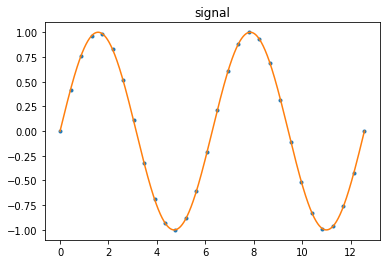

In [14]:
# Signal
T = 4*np.pi
t, dt = np.linspace(0, T, N, retstep=True)

w_max = 1
x = np.sin(w_max*t)
plt.plot(t, x, '.');

y = np.linspace(0, T, 1000)
plt.title('signal')
plt.plot(y, np.sin(w_max*y))

assert 2*np.pi/(T/N) >= 2.5*w_max, "Kotelnikov's theorem f_s > 2*f_max (in practice > 2.5*f_s)"

## Upsampling

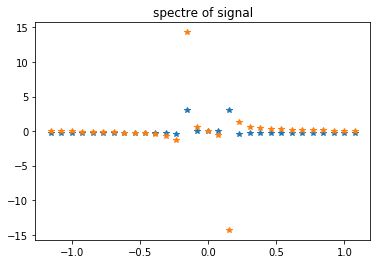

In [15]:
x_w = np.fft.fft(x)
w = np.fft.fftfreq(len(x_w), dt)
plt.title('spectre of signal')
plt.plot(w, x_w.real, '*');
plt.plot(w, x_w.imag, '*');

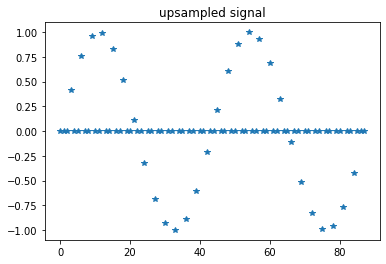

In [16]:
pad = np.tile(np.zeros(U-1), (len(x)-1, 1))
x_up = np.r_[np.c_[x[:-1, None], pad].flatten(), x[-1]]

plt.title('upsampled signal')
plt.plot(x_up, '*');

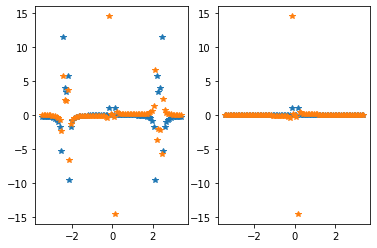

In [17]:
Nu = len(x_up)
x_up_w = np.fft.fft(x_up)
w = np.fft.fftfreq(Nu, dt/U)

filter = np.zeros_like(w, dtype=bool)
filter[np.where(abs(w) <= 1/(2*dt))[0]] = 1

plt.subplot('121')
# plt.title('spectre of upsampled signal')
plt.plot(w, x_up_w.real, '*')
plt.plot(w, x_up_w.imag, '*');

plt.subplot('122')
# plt.title('the filtered spectre')
plt.plot(w, x_up_w.real*filter, '*')
plt.plot(w, x_up_w.imag*filter, '*');

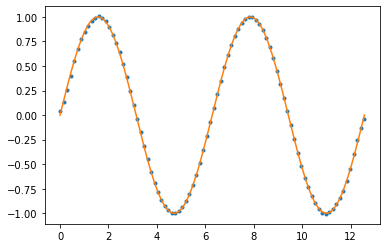

In [18]:
t_up = np.linspace(0, T, len(x_up))
plt.plot(t_up, np.fft.ifft(U*x_up_w * filter).real, '.');
plt.plot(y, np.sin(w_max*y));

## Downsampling

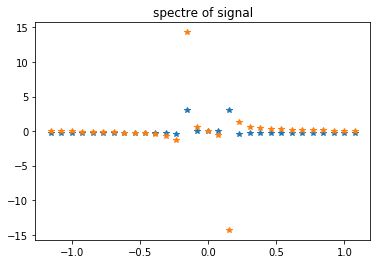

In [19]:
x_w = np.fft.fft(x)
w = np.fft.fftfreq(len(x_w), dt)
plt.title('spectre of signal')
plt.plot(w, x_w.real, '*');
plt.plot(w, x_w.imag, '*');

In [20]:
filter = np.zeros_like(w, dtype=bool)
filter[abs(w) <= 1/(2*D*dt)] = 1

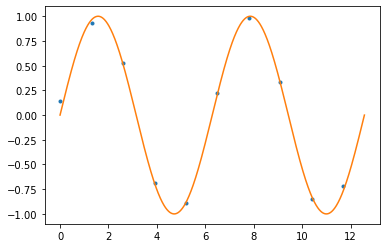

In [21]:
x_down = np.fft.ifft(x_w*filter).real[::D]
plt.plot(t[::D], x_down, '.');
plt.plot(y, np.sin(w_max*y));

## Rational-factor re-sampling

In [22]:
x_w = np.fft.fft(x)
x_up_down_w = np.insert(x_w, N//2, np.zeros(N*(R[0]-1)))

w = np.fft.fftfreq(len(x_up_down_w), dt/R[0])
w_cut = min(1/(2*dt), R[0]/(2*R[1]*dt))

filter = np.zeros_like(w, dtype=bool)
filter[abs(w) <= w_cut] = 1

x_up_down = R[0]*np.fft.ifft(x_up_down_w*filter).real[::R[1]]

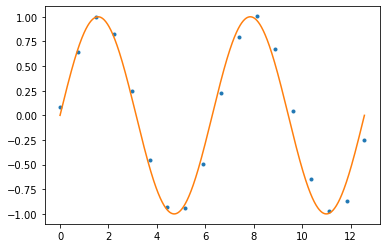

In [23]:
plt.plot(np.linspace(0, T, len(x_up_down)), x_up_down, '.');
plt.plot(y, np.sin(w_max*y));